# Computer Vision

## Lab 4

### Imports

In [2]:
# Computation
import numpy as np
import cv2
from skimage import color, feature

# Plotting
import matplotlib.pyplot as plt

In [3]:
image = np.array(cv2.imread("./image-83.jpg")[:,:,::-1], dtype=np.float32) / 255
image_gray = color.rgb2gray(image)

mask = np.array(cv2.imread("./mask-83.png")[:,:,::-1], dtype=np.float32) / 255
mask_gray = color.rgb2gray(mask)

### Section 1 - Canny Edge Detector

In [47]:
truncate = 4.0

def canny_edge_detector(image, sigma, low_threshold, high_threshold):
    fig = plt.figure(figsize=(20, 10))
    
    fig.add_subplot(1, 5, 1)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    
    # 1. Apply gaussian filter
    size = np.uint8(2 * (np.floor(truncate * sigma + 0.5)) + 1)
    gaussian_image = cv2.GaussianBlur(image, ksize=(size, size), sigmaX=sigma, sigmaY=sigma)

    fig.add_subplot(1, 5, 2)
    plt.imshow(gaussian_image, cmap="gray")
    plt.axis('off')
    
    # 2. Gradient magnitude and direction
    Gx = cv2.Sobel(gaussian_image, -1, 1, 0, ksize=3)
    Gy = cv2.Sobel(gaussian_image, -1, 0, 1, ksize=3)
    
    fig.add_subplot(1, 5, 3)
    plt.imshow(Gx, cmap="gray")
    plt.axis('off')
    
    fig.add_subplot(1, 5, 4)
    plt.imshow(Gy, cmap="gray")
    plt.axis('off')
    
    G = np.hypot(Gx, Gy)
    G = G / G.max() # Normalize
    theta = np.arctan2(Gy, Gx)
    
    fig.add_subplot(1, 5, 5)
    plt.imshow(G, cmap="gray")
    plt.axis('off')
    
    # 3. Non-maximal suppression
    def _non_maximal_suppression(_theta):
        pass
    
    NMS = _non_maximal_suppression(theta)
    
    # 4. Hysteresis thresholding
    HT = NMS
    
    return HT

In [35]:
sigma = 1
low_threshold = None
high_threshold = None

[3.1415927 3.1415927 3.1415927 ... 3.1415927 3.1415927 3.1415927]


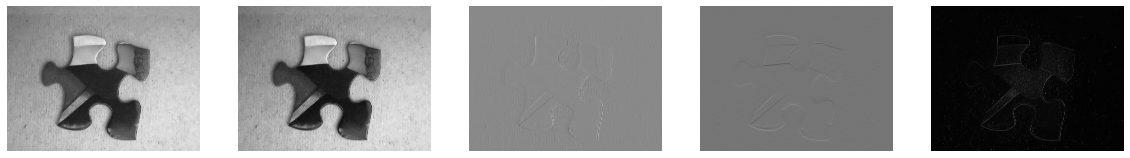

In [48]:
canny_image = canny_edge_detector(image_gray, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

In [37]:
lib_canny = feature.canny(image_gray, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

(-0.5, 5119.5, 3839.5, -0.5)

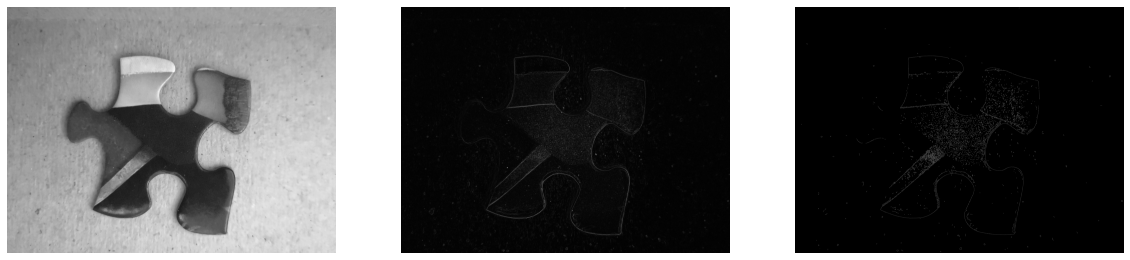

In [29]:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(canny_image, cmap="gray")
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(lib_canny, cmap="gray")
plt.axis('off')

### Section 2 - Harris Corner Detector

### Section 3 - HOG (Histogram of Oriented Gradients) Descriptor